In [1]:
import pandas as pd
import numpy as np
from scipy.sparse import csr_matrix
from scipy.sparse import vstack
import scipy.stats
import psutil
import math
import matplotlib.pyplot as plt
import cooltools
import cooltools.lib.plotting
from mpl_toolkits.axes_grid1 import make_axes_locatable
import bioframe

/home/kimj7/miniconda3/envs/R_python_env/lib/python3.8/site-packages/cooltools/lib/numutils.py:652: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def iterative_correction_symmetric(
/home/kimj7/miniconda3/envs/R_python_env/lib/python3.8/site-packages/cooltools/lib/numutils.py:727: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def iterative_correction_asymmetric(

In [42]:
# Getting % usage of virtual_memory ( 3rd field)
print('RAM memory % used:', psutil.virtual_memory()[2])
# Getting usage of virtual_memory in GB ( 4th field)
print('RAM Used (GB):', psutil.virtual_memory()[3]/1000000000)

RAM memory % used: 19.1
RAM Used (GB): 15.31465728


In [6]:
def sparseM_subset(M,cell_info,subsetBy,selection_list):
    TF = cell_info[subsetBy].isin(selection_list)
    M_subset = M[:,TF]
    print(selection_list,' subset shape: ',M_subset.get_shape())
    return(M_subset)

def subsampling_normalization(M_lst,Z,fraction,BinSize):
    N = len(M_lst)
    M_sum_arr_lst = []
    Means_lst = []
    Max_lst = []
    for i in range(N):
        M_sum_arr = np.array(csr_matrix.sum(M_lst[i],axis=0))[0] # sum values for each cell (sum rows for each column)
        M_sum_arr_lst.append(M_sum_arr)
        Means_lst.append(np.nanmean(M_sum_arr)) # the average of signal sum per cell
        Max_lst.append(np.max(M_sum_arr))
    Bins = range(0,np.max(Max_lst),BinSize)
    counts_lst = []
    bins_lst = []
    ########################################
    fig, axs = plt.subplots(2,sharex=True,sharey=True)
    for i in range(N):
        Counts_i, Bins_i, Bars_i = axs[0].hist(M_sum_arr_lst[i],Bins,alpha=0.5,histtype='step',label=i)
        counts_lst.append(Counts_i) # counts are y-coord value for each left-right bin in the histograms (total elements are 1 less than that of bins)
    mX = np.min(np.row_stack(counts_lst),axis=0) # for each bin, find the minimum count among all matrices. mX is array of minimum y-coord values in histgram 
    cutoff = np.min(Z*Means_lst) # corrosponds to the average signal-sum per cell value of the matrix that has the lowest such value
    axs[0].axvline(x=cutoff,ls='--',color='black')
    Bins_start = Bins[:-1]
    mX[Bins_start<cutoff] = 0 # mX values are 'how many cells to subset' for each bin. Anything lower than the cutoff is set to 0, thus no subsetting from below those bins
    
    ####################################
    M_subset_index_lst = []
    for i in range(N):
        M_i_subset_lst = []
        for j in range(len(Bins_start)):
            tf1 = M_sum_arr_lst[i]<Bins_start[j]+BinSize
            tf2 = M_sum_arr_lst[i]>=Bins_start[j]
            tf = np.logical_and(tf1,tf2) # get cells with sum values between the two bin-edges 
            items = np.nonzero(tf)  # get the index of those cells
            items_p = np.random.permutation(items)[0] # permutation of items (indexes)
            items_p_n = items_p[0:int(mX[j])] # just grab first mX[j] number of cells, ie random subsetting
            #print(len(items_p_n))
            M_i_subset_lst.append(items_p_n)
        M_i_subset_index = np.concatenate(M_i_subset_lst) # indexes of cells to subset for the Matrix_i
        M_subset_index_lst.append(M_i_subset_index)
        
    ##############################
    M_subset_lst = []
    for i in range(N):
        M_i_subset = M_lst[i][:,M_subset_index_lst[i]]
        M_subset_lst.append(M_i_subset)
        v = np.array(csr_matrix.sum(M_subset_lst[i],axis=0))[0]
        
        axs[1].hist(v,Bins,alpha=0.5,histtype='step',label=i)

    # plot aesthetics
    for a in range(2):
        axs[a].legend(title='Matrix_n')
        axs[a].set_ylabel('counts')
    axs[0].set_title('Before normalization')
    axs[1].set_title('After normalization')
    axs[1].set_xlabel('signal-sum per cell')
    
    return(M_subset_lst)

def compute_corr_bulk(M, Method):
    df = pd.DataFrame(M.toarray())
    M_corr = df.T.corr(method=Method,min_periods=1,numeric_only=True)
    bulk = np.array(df.sum(axis=1))/len(df.columns)
    return M_corr,bulk
def make_corr_saddle(compute_corrbulk_out,ignore_diag = True):
    M_corr_df = compute_corrbulk_out[0]
    bulk = compute_corrbulk_out[1]
    sort_ind = np.argsort(bulk)
    bulk_sorted = bulk[sort_ind]
    M_corr_df_sorted = np.array(M_corr_df.iloc[sort_ind,sort_ind])
    if ignore_diag == True:
        np.fill_diagonal(M_corr_df_sorted, np.nan)
    else:
        print('main diagonal kept')
    return (M_corr_df_sorted, bulk_sorted)


In [4]:
sparseMatrix_binned = scipy.sparse.load_npz('./sparseMatrix_Binned_550kb.npz')
Coordinate = bioframe.read_table('Coordinate_Binned_550kb.bed',schema='bed3')
cells = pd.read_csv('/mnt/g/genomics/10_16_23_CA1/Allsamples_mm10_cells.txt', header=None,sep='#')
clusters = pd.read_csv('/mnt/g/genomics/10_16_23_CA1/Allsamples_mm10_clusters.txt', header=None)

cell_clusters = pd.concat([cells,clusters],axis=1)
cell_clusters.columns = ['sample','cell','cluster']

In [7]:
c1 = ["C5"]   # 'dorsal'
c2 = ["C6"]   # 'ventral'

M_c1 = sparseM_subset(sparseMatrix_binned,cell_clusters,subsetBy='cluster',selection_list=c1)
M_c2 = sparseM_subset(sparseMatrix_binned,cell_clusters,subsetBy='cluster',selection_list=c2)


['C5']  subset shape:  (4944, 5549)
['C6']  subset shape:  (4944, 4404)


In [8]:
########### plot pair histogram
Z = 1 # scale factor for average
fraction = 1 # sampling fraction
binsize = 500


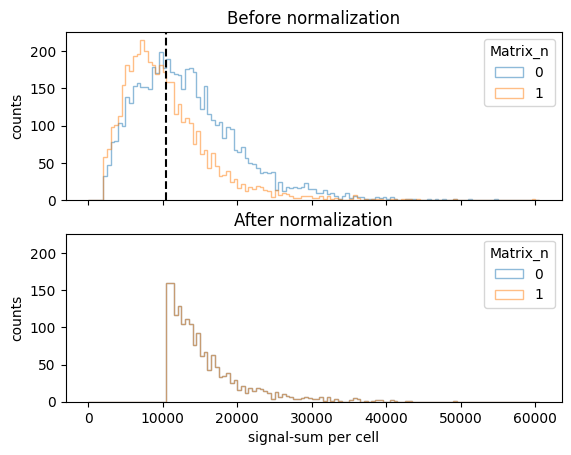

In [9]:
t = subsampling_normalization([M_c1,M_c2],Z,fraction,BinSize=500)    


In [10]:
t

[<4944x1753 sparse matrix of type '<class 'numpy.int64'>'
 	with 5222140 stored elements in Compressed Sparse Row format>,
 <4944x1753 sparse matrix of type '<class 'numpy.int64'>'
 	with 5232228 stored elements in Compressed Sparse Row format>]

In [11]:
M_dats = t

dats_corr = []
dats_corr_saddle = []
for i in range(len(M_dats)):
    print(i)
    t = compute_corr_bulk(M_dats[i],'spearman')
    u = make_corr_saddle(t,ignore_diag=True)
    dats_corr.append(t)
    dats_corr_saddle.append(u)

0
1


In [41]:

bg = pd.concat([Coordinate,pd.DataFrame(dats_corr[0][1])],axis=1)
bg.to_csv('C5_550kb_dorsal.bedgraph',sep='\t',index=False,header=False)

bg = pd.concat([Coordinate,pd.DataFrame(dats_corr[1][1])],axis=1)
bg.to_csv('C6_550kb_ventral.bedgraph',sep='\t',index=False,header=False)



#dats_corr[0][1]


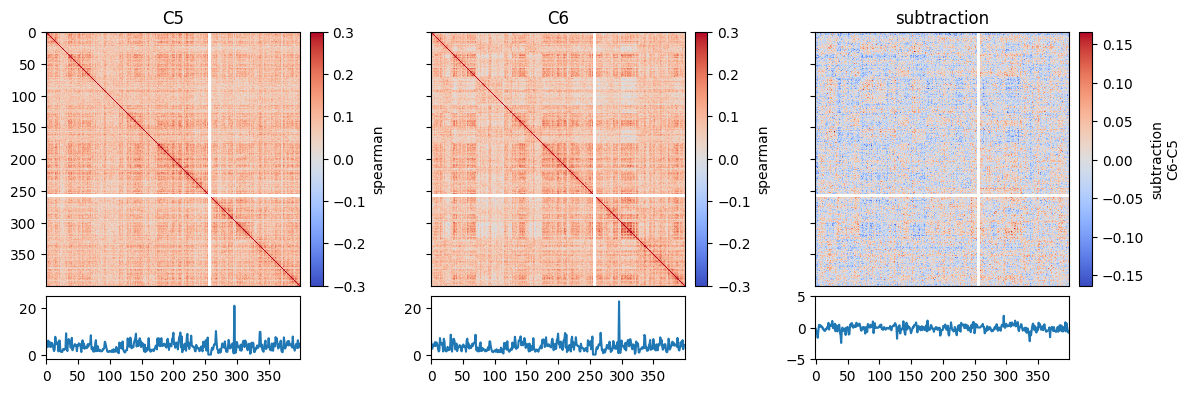

In [16]:
########################### raw matrix ###########################

f, axs = plt.subplots(
    figsize=(12, 6),
    nrows=1,
    ncols=3, # three columns, first two will be regular HiC plot, third will be log2ratio
    sharex='col',
    sharey='row'
)

dats = dats_corr

sub_titles = c1+c2+['subtraction']

vMin,vMax = -0.3,0.3
sMin,sMax = -2,25

start,end = 100,500


### colors to try: 'fall' 'blues' 'acidblues', "nmeth'
for i in range(len(dats)):
    d = dats[i]
    ax = axs[i]
    im = ax.matshow(
        d[0].iloc[start:end,start:end],
        cmap='coolwarm',
        vmin=vMin,vmax=vMax
    );
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)
    plt.colorbar(im, cax=cax, label='spearman');
    ax.set_title(sub_titles[i])
    ax.xaxis.set_visible(False)

    ax1 = divider.append_axes("bottom", size="25%", pad=0.1, sharex=ax)
    ax1.plot(d[1][start:end])
    ax1.set_ylim(sMin,sMax)

## contrast plot ####
ax = axs[2]
im = ax.matshow(
    dats[1][0].iloc[start:end,start:end]-dats[0][0].iloc[start:end,start:end],
    cmap='coolwarm',
#    vmin=-0.1,vmax=0.1,
    )
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
plt.colorbar(im, cax=cax, label='subtraction'+'\n'+str(sub_titles[1])+'-'+str(sub_titles[0]));
    
ax.set_title(sub_titles[2])
ax.xaxis.set_visible(False)

ax1 = divider.append_axes("bottom", size="25%", pad=0.1, sharex=ax)
ax1.plot(dats[1][1][start:end]-dats[0][1][start:end])
ax1.set_ylim(-5,5)


plt.tight_layout()

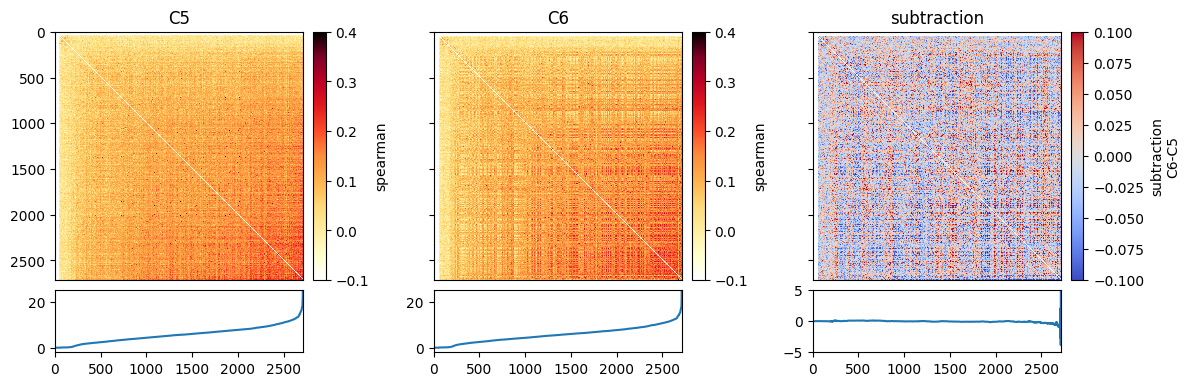

In [26]:
########################### raw matrix ###########################

f, axs = plt.subplots(
    figsize=(12, 6),
    nrows=1,
    ncols=3, # three columns, first two will be regular HiC plot, third will be log2ratio
    sharex='col',
    sharey='row'
)

dats = dats_corr_saddle

sub_titles = c1+c2+['subtraction']

vMin,vMax = -0.1,0.4
sMin,sMax = -2,25

### colors to try: 'fall' 'blues' 'acidblues', "nmeth'
for i in range(len(dats)):
    d = dats[i]
    ax = axs[i]
    im = ax.matshow(
        d[0],
        cmap='fall',
        vmin=vMin,vmax=vMax
    );
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)
    plt.colorbar(im, cax=cax, label='spearman');
    ax.set_title(sub_titles[i])
    ax.xaxis.set_visible(False)

    ax1 = divider.append_axes("bottom", size="25%", pad=0.1, sharex=ax)
    ax1.plot(d[1])
    ax1.set_ylim(sMin,sMax)

## contrast plot ####
ax = axs[2]
im = ax.matshow(
    dats[1][0]-dats[0][0],
    cmap='coolwarm',
    vmin=-0.1,vmax=0.1,
    )
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
plt.colorbar(im, cax=cax, label='subtraction'+'\n'+str(sub_titles[1])+'-'+str(sub_titles[0]));
    
ax.set_title(sub_titles[2])
ax.xaxis.set_visible(False)

ax1 = divider.append_axes("bottom", size="25%", pad=0.1, sharex=ax)
ax1.plot(dats[1][1]-dats[0][1])
ax1.set_ylim(-5,5)


plt.tight_layout()

In [261]:
np.array(t[1][1])


array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0, 157, 136, 115, 113, 106,
       100, 104,  76,  81,  62,  59,  43,  50,  42,  34,  35,  34,  25,
        29,  16,  20,  13,  13,  14,  14,  15,  13,  12,   3,   7,   7,
         7,   9,   6,   2,   3,   4,   4,   5,   3,   2,   3,   1,   2,
         1,   1,   1,   0,   0,   0,   5,   3,   0,   1,   0,   1,   2,
         1,   0,   0,   1,   1,   0,   0,   1,   1,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   1,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0])